<a href="https://colab.research.google.com/github/jesusGS01/BDGE/blob/main/hbase/sesion5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoSQL (HBase) (sesión 5)

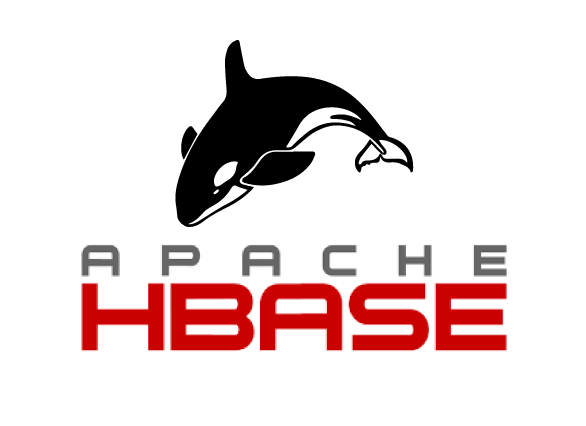



Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en la máquina virtual.

Con HBase vamos a simular un modo _semi-clúster_ con una sola máquina.


Instalamos la versión 8 de Java y la seleccionamos como opción por defecto:


In [1]:
%%capture
import os       #importing os to set environment variable
def install_java():
  !apt-get update -qq > /dev/null
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()
!update-java-alternatives -s java-1.8.0-openjdk-amd64

In [2]:
!pip install bs4 lxml

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=41f42a06ab7b550797c0fa7a5481ef086e9300b5bc6136a6e12094b2609812ec
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [3]:
# Determinar qué versión 2.x es mayor de hbase
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re

version_re = re.compile(r'^(2\.[0-9]+(\.[0-9]+)?)')
req = Request("https://downloads.apache.org/hbase/")
html_page = urlopen(req)

soup = BeautifulSoup(html_page)

bigger2x = '2.0.0'  # Base version 2.x.x
for link in soup.findAll('a'):
  mresult = version_re.match(link.get_text())
  if mresult and mresult.group(0) > bigger2x:
    bigger2x = mresult.group(0)

In [4]:
%env HBASE_VERSION=$bigger2x

env: HBASE_VERSION=2.5.6


In [5]:
%%bash
wget -q https://downloads.apache.org/hbase/$HBASE_VERSION/hbase-$HBASE_VERSION-bin.tar.gz
tar -xzf hbase-$HBASE_VERSION-bin.tar.gz && rm -rf hbase-$HBASE_VERSION-bin.tar.gz

In [6]:
%%bash
hbase-$HBASE_VERSION/bin/start-hbase.sh
hbase-$HBASE_VERSION/bin/hbase-daemon.sh restart thrift

running master, logging to /content/hbase-2.5.6/bin/../logs/hbase--master-0bdee47c9a51.out
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-0bdee47c9a51.out
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-0bdee47c9a51.out
no thrift to stop because no pid file /tmp/hbase--thrift.pid
running thrift, logging to /content/hbase-2.5.6/bin/../logs/hbase--thrift-0bdee47c9a51.out


In [7]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [8]:
import gzip
from urllib.request import Request,urlopen
import io
import os
import os.path as path

def download_csv(baseurl, filename):
    file = path.abspath(path.join(os.getcwd(),filename))
    request = Request(baseurl + '/' + filename+'.gz?raw=true')
    response = urlopen(request)
    buf = io.BytesIO(response.read())
    f = gzip.GzipFile(fileobj=buf)
    data = f.read()
    with open (filename, 'wb') as ff:
      ff.write(data)

baseurl = 'https://github.com/dsevilla/bdge-data/blob/master/es.stackoverflow/'
download_csv(baseurl, 'Posts.csv')
download_csv(baseurl, 'Users.csv')
download_csv(baseurl, 'Tags.csv')
download_csv(baseurl, 'Comments.csv')
download_csv(baseurl, 'Votes.csv')

In [9]:
!pip install happybase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for happybase: filename=happybase-1.2.0-py2.py3-none-any.whl size=26602 sha256=bf1a3f29347c8ce25aa961c4c9e8fcc07254499c8f0a47d70f88b2909dbdf339
  Stored in directory: /root/.cache/pip/wheels/95/d9/40/aef1e677ca6b53d419ead4f533d2a44198a1ce0b7b36b2437f
  Created wheel for thriftpy2: filename=thriftpy2-0.4.17-cp310-cp310-linux_x86_64.whl size=1382288 sha256=3150865990680eeeed26e2ae2c136f44ffa150631ca94c694598ea675d821df9
  Stored in directory: /root/.cache/pip/wheels/b3/ca/c1/bd8e4cd94145e4e79882fdf705ca021a7a7632248ce6

In [10]:
import happybase
from contextlib import contextmanager

HBASEHOST = 'localhost'

class Connection():

    def __init__(self, host):
        self.host = host
        self._genpool()

    def _genpool(self):
        self.pool = happybase.ConnectionPool(size=5, host=self.host)

    @contextmanager
    def connection(self):
        for _ in range(5): # Probar 5 veces a regenerar el pool
            for _ in range(5): # Probar 5 veces a conectar
                with self.pool.connection() as connection:
                    try:
                        connection.tables()
                        yield connection
                        return
                    except Exception as e:
                        pass
            self._genpool()
        raise Exception("HBase Connection Error")

In [11]:
pool = Connection(HBASEHOST)

Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [12]:
# Create tables
tables = ['posts', 'votes', 'users', 'tags', 'comments']
for t in tables:
    try:
        with pool.connection() as connection:
            connection.create_table(
                t,
                {
                    'rawdata': dict(max_versions=1,compression='GZ')
                })
    except Exception as e:
        print("Database already exists: {0}. {1}".format(t, e))
        pass
with pool.connection() as connection:
    print(connection.tables())

[b'comments', b'posts', b'tags', b'users', b'votes']


El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [13]:
import csv

def csv_to_hbase(file, tablename, cf):
    with pool.connection() as connection, open(file) as f:
        table = connection.table(tablename)

        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        columns = [cf + ':' + c for c in columns]

        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns[1:], row[1:])))

In [14]:
for t in tables:
    print(f"Importando tabla {t}...")
    %time csv_to_hbase(t.capitalize() + '.csv', t, 'rawdata')

Importando tabla posts...
CPU times: user 5.78 s, sys: 168 ms, total: 5.94 s
Wall time: 19.6 s
Importando tabla votes...
CPU times: user 1.97 s, sys: 61.4 ms, total: 2.03 s
Wall time: 6.09 s
Importando tabla users...
CPU times: user 1.56 s, sys: 46.3 ms, total: 1.61 s
Wall time: 5.3 s
Importando tabla tags...
CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 47.5 ms
Importando tabla comments...
CPU times: user 2.15 s, sys: 64.2 ms, total: 2.21 s
Wall time: 5.7 s


### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.

In [29]:
with pool.connection() as connection:
    posts = connection.table('posts')

Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [16]:
posts.row(b'5',columns=[b'rawdata:Body'])

{b'rawdata:Body': b'<p>\xc2\xbfCu\xc3\xa1l es la forma m\xc3\xa1s eficiente de separar un string en <code>c++</code>? como el que se muestra en el c\xc3\xb3digo, el cual contiene espacios entre las palabras, este es el m\xc3\xa9todo que yo estoy usando actualmente.</p><br/><br/><pre><code>#include <iostream><br/>#include <sstream><br/><br/>int main(int argc, char** argv){<br/><br/>    std::string str("Texto para dividir");<br/>    std::istringstream isstream(str);<br/><br/>    while(!isstream.eof()){<br/><br/>        std::string tempStr;<br/><br/>        isstream >> tempStr;<br/><br/>        std::cout << tempStr << std::endl;<br/>    }<br/><br/>    return 0;<br/>}<br/></code></pre><br/>'}

El siguiente código permite mostrar de forma amigable las tablas extraídas de la base de datos en forma de diccionario:

In [19]:
# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        htmltext = ["<table width=100%>"]
        for key, value in self.items():
            htmltext.append("<tr>")
            htmltext.append("<td>{0}</td>".format(key.decode('utf-8')))
            htmltext.append("<td>{0}</td>".format(value.decode('utf-8')))
            htmltext.append("</tr>")
        htmltext.append("</table>")
        return ''.join(htmltext)

In [20]:
# Muestra cómo queda la fila del Id del Post 9997
DictTable(posts.row(b'5'))

rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6
rawdata:Body,"¿Cuál es la forma más eficiente de separar un string en c++? como el que se muestra en el código, el cual contiene espacios entre las palabras, este es el método que yo estoy usando actualmente.#include #include int main(int argc, char** argv){ std::string str(""Texto para dividir""); std::istringstream isstream(str); while(!isstream.eof()){ std::string tempStr; isstream >> tempStr; std::cout << tempStr << std::endl; } return 0;}"
rawdata:ClosedDate,
rawdata:CommentCount,1
rawdata:CommunityOwnedDate,
rawdata:CreationDate,2015-10-30T01:15:27.267
rawdata:FavoriteCount,
rawdata:LastActivityDate,2017-03-04T04:16:19.167
rawdata:LastEditDate,2016-09-27T17:46:24.900
rawdata:LastEditorDisplayName,


In [23]:
DictTable(posts.row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6


Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [24]:
row = posts.row(b'5')
for key, value in row.items():
    print("Key = '%s', Value = '%s'" % (key, value.decode('utf-8')[:40]))

Key = 'b'rawdata:AcceptedAnswerId'', Value = '208'
Key = 'b'rawdata:AnswerCount'', Value = '6'
Key = 'b'rawdata:Body'', Value = '<p>¿Cuál es la forma más eficiente de se'
Key = 'b'rawdata:ClosedDate'', Value = ''
Key = 'b'rawdata:CommentCount'', Value = '1'
Key = 'b'rawdata:CommunityOwnedDate'', Value = ''
Key = 'b'rawdata:CreationDate'', Value = '2015-10-30T01:15:27.267'
Key = 'b'rawdata:FavoriteCount'', Value = ''
Key = 'b'rawdata:LastActivityDate'', Value = '2017-03-04T04:16:19.167'
Key = 'b'rawdata:LastEditDate'', Value = '2016-09-27T17:46:24.900'
Key = 'b'rawdata:LastEditorDisplayName'', Value = ''
Key = 'b'rawdata:LastEditorUserId'', Value = '729'
Key = 'b'rawdata:OwnerDisplayName'', Value = ''
Key = 'b'rawdata:OwnerUserId'', Value = '24'
Key = 'b'rawdata:ParentId'', Value = ''
Key = 'b'rawdata:PostTypeId'', Value = '1'
Key = 'b'rawdata:Score'', Value = '19'
Key = 'b'rawdata:Tags'', Value = '<c++><string>'
Key = 'b'rawdata:Title'', Value = '¿Cómo separar las palabras que contiene

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [26]:
max_len = 0
for key, data in posts.scan(columns=[b'rawdata:Body']):
    cur_len = len(data[b'rawdata:Body'].decode('utf-8'))
    if cur_len > max_len:
        max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

Máxima longitud: 38134 caracteres.


### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas. Para acceder al shell de HBase, tenemos que contactar al contenedor `hbase-regionserver`, de esta forma:

```bash
hbase-$HBASE_VERSION/bin/hbase shell
```

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`". La base de datos permite implementar filtros que nos permiten buscar esto de forma muy sencilla. Los veremos después.

In [31]:
!hbase-$HBASE_VERSION/bin/hbase shell

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.5.6, r6bac842797dc26bedb7adc0759358e4c8fd5a992, Sat Oct 14 23:36:46 PDT 2023
Took 0.0021 seconds                                                             
hbase:001:0> disable 'posts'
Took 1.6924 seconds                                                             
hbase:002:0> alter 'posts', {NAME => 'comments', VERSIONS => 1}
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.2429 seconds                                                             
hbase:003:0> enable 'posts'
Took 0.6934 seconds                                                             
hbase:004:0> exit


In [36]:
with pool.connection() as connection:
    comments = connection.table('comments')
    posts = connection.table('posts')

    with posts.batch(batch_size=500) as bp:
        # Hacer un scan de la tabla
        for key, data in comments.scan():
            comment = {'comments:' +
                       d.decode('utf-8').split(':')[1] + "_" +
                       key.decode('utf-8') :
                       data[d] for d in data.keys()}
            bp.put(data[b'rawdata:PostId'], comment)

In [33]:
DictTable(posts.row(b'7251'))

comments:CreationDate_13163,2016-04-07T20:02:25.850
comments:CreationDate_13164,2016-04-07T20:02:50.460
comments:CreationDate_13165,2016-04-07T20:03:19.193
comments:CreationDate_13170,2016-04-07T20:20:02.310
comments:CreationDate_13171,2016-04-07T20:20:30.937
comments:CreationDate_13236,2016-04-08T16:02:35.247
comments:CreationDate_13239,2016-04-08T16:25:25.647
comments:CreationDate_13285,2016-04-08T19:15:03.023
comments:CreationDate_13288,2016-04-08T19:18:33.813
comments:CreationDate_13289,2016-04-08T19:20:19.410
comments:CreationDate_13291,2016-04-08T19:21:25.510


In [34]:
%timeit q = posts.row(b'7251')

1.91 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
from functools import reduce

def doit():
    q = posts.row(b'7251')
    (s,n) = reduce(lambda res, e:
                    (res[0]+len(e[1].decode('utf-8')), res[1]+1) if e[0].decode('utf-8').startswith('comments:Text') else res
                   , q.items(), (0,0))
    return (s/n)

%timeit doit()
# MySQL -> 1.12 ms
# HBase -> 1.47 ms

1.52 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## EJERCICIO: ¿Cómo sería el código para saber qué usuarios han comentado un post en particular?

## Wikipedia

Como otro ejemplo de carga de datos y de organización en HBase, veremos de manera simplificada el ejemplo de la wikipedia visto en teoría.

A continuación se descarga una pequeña parte del fichero de la wikipedia en XML:

In [38]:
download_csv('https://github.com/dsevilla/bdge-data/blob/master/wikipedia/','eswiki.xml')

Se crea la tabla para albergar la `wikipedia`. Igual que la vista en teoría, pero aquí se usa `wikipedia` en vez de `wiki` para que no colisionen la versión completa con la reducida.

De nuevo en el `shell` de HBase:

```
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia'
```

In [39]:
!hbase-$HBASE_VERSION/bin/hbase shell

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.5.6, r6bac842797dc26bedb7adc0759358e4c8fd5a992, Sat Oct 14 23:36:46 PDT 2023
Took 0.0020 seconds                                                             
hbase:001:0> create 'wikipedia' , 'text', 'revision'
Created table wikipedia
Took 1.1042 seconds                                                             
=> Hbase::Table - wikipedia
hbase:002:0> disable 'wikipedia'
Took 0.4186 seconds                                                             
.hbase.HConstants::ALL_VERSIONS }
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.1681 seconds                                                             
doop.hbase.HConstants::ALL_VERSIONS }
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.0465 seconds                                            

Este código, visto en teoría, recorre el árbol XML construyendo documentos y llamando a la función `callback` con cada uno. Los documentos son diccionarios con las claves encontradas dentro de los tags `<page>...</page>`.

In [40]:
import xml.sax
import re

class WikiHandler(xml.sax.handler.ContentHandler):

    def __init__(self):
        self._charBuffer = ''
        self.document = {}

    def _getCharacterData(self):
        data = self._charBuffer
        self._charBuffer = ''
        return data

    def parse(self, f, callback):
        self.callback = callback
        xml.sax.parse(f, self)

    def characters(self, data):
        self._charBuffer = self._charBuffer + data

    def startElement(self, name, attrs):
        if name == 'page':
        # print 'Start of page'
            self.document = {}
        if re.match(r'title|timestamp|username|comment|text', name):
            self._charBuffer = ''

    def endElement(self, name):
        if re.match(r'title|timestamp|username|comment|text', name):
            self.document[name] = self._getCharacterData()
            # print(name, ': ', self.document[name][:20])
        if 'revision' == name:
            self.callback(self.document)

El codigo a continuación, cada vez que el código anterior llama a la función `processdoc()` se añade un documento a la base de datos.

In [41]:
import time
import os
import gzip

class FillWikiTable():
    """Llena la tabla Wiki"""
    def __init__(self,connection):
        # Conectar a la base de datos a través de Thrift
        self.table = connection.table('wikipedia')

    def run(_s):
        def processdoc(d):
            print("Callback called with {0}".format(d['title']))
            tuple_time = time.strptime(d['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            timestamp = int(time.mktime(tuple_time))
            _s.table.put(d['title'],
                         {'text:': d.get('text',''),
                          'revision:author': d.get('username',''),
                          'revision:comment': d.get('comment','')},
                         timestamp=timestamp)

        with open('eswiki.xml','r') as f:
            start = time.time()
            WikiHandler().parse(f, processdoc)
            end = time.time()
            print ("End adding documents. Time: %.5f" % (end - start))

In [42]:
with pool.connection() as connection:
    FillWikiTable(connection).run()

Callback called with Wikipedia:Artículos solicitados
Callback called with Andorra
Callback called with Argentina
Callback called with Geografía de Andorra
Callback called with Demografía de Andorra
Callback called with Comunicaciones de Andorra
Callback called with Artes visuales
Callback called with Agricultura
Callback called with Astronomía galáctica
Callback called with ASCII
Callback called with Arquitectura
Callback called with Anoeta
Callback called with Ana María Matute
Callback called with Agujero negro
Callback called with Anarquía
Callback called with América del Norte
Callback called with América del Sur
Callback called with Asia
Callback called with Año
Callback called with Asaph Hall
Callback called with Afganistán
Callback called with Arqueología
Callback called with Wikipedia:Anuncios
Callback called with Commodore Amiga
Callback called with Commodore Amiga 500
Callback called with Francesc Aguilar Villalonga
Callback called with Aquifoliaceae
Callback called with Sapin

El código a continuación permite ver las diferentes versiones de una revisión. Como la versión reducida es muy pequeña no da lugar a que haya ninguna revisión, pero con este código se vería. Hace uso del _shell_ de HBase:

```
get 'wikipedia', 'Commodore Amiga', {COLUMN => 'revision',VERSIONS=>10}
```

### Enlazado de documentos en la wikipedia

Los artículos de la wikipedia llevan enlaces entre sí, incluyendo referencias del tipo `[[artículo referenciado]]`. Se pueden extraer estos enlaces y se puede construir un grafo de conexiones. Para cada artículo, se anotarán qué enlaces hay que salen de él y hacia qué otros artículos enlazan y también qué enlaces llegan a él. Esto se hará con dos familias de columnas, `from` y `to`.

En cada momento, se añadirá una columna `from:artículo` cuando un artículo nos apunte, y otras columnas `to:articulo` con los artículos que nosotros enlazamos.

In [43]:
import sys

class BuildLinks():
    """Llena la tabla de Links"""
    def __init__(self,connection):
        # Create table
        try:
            connection.create_table(
                "wikilinks",
                {
                    'from': dict(bloom_filter_type='ROW',max_versions=1),
                    'to' : dict(bloom_filter_type='ROW',max_versions=1)
                })
        except:
            print ("Database wikilinks already exists.")
            pass

        self.table = connection.table('wikilinks')
        self.wikitable = connection.table('wikipedia')

    def run(self):
        print("run")
        linkpattern = r'\[\[([^\[\]\|\:\#][^\[\]\|:]*)(?:\|([^\[\]\|]+))?\]\]'
        # target, label

        with self.table.batch(batch_size=500) as b:
            for key, data in self.wikitable.scan():
                to_dict = {}
                doc = key.strip().decode('utf-8')
                print("\n{0}:".format(doc))
                for mo in re.finditer(linkpattern, data[b'text:'].decode('utf-8')):
                    (target, label) = mo.groups()

                    target = target.strip()

                    if target == '':
                        continue

                    label = '' if not label else label
                    label = label.strip()

                    to_dict['to:' + target] = label

                    sys.stdout.write(".")

                    b.put(target, {'from:' + doc : label})

                if bool(to_dict):
                    b.put(doc, to_dict)

In [44]:
with pool.connection() as connection:
    BuildLinks(connection).run()

run

A fala:
.
AGA:
.....
ALGOL:
.................................
ASCII:
.......................................................................................................................................................................................................
Abreviatura:
................................
Acacia:
................................................................................................
Acamptoclados:
.
Acarreo:
................
Acento léxico:
.............................................
Achlaena:
.
Achmatherum:
.
Achneria:
.
Achyrodes:
.
Aciachne acicularis:
..............................
Acrobatidae:
...............
Acroceras:
....................................................................
Acróstico:
................
Activa tantum:

Actuación:
........................
Actual rey de Francia:
.
Ada:
................
Adeudo por domiciliación:
................
Adjetivo:
..........................................
Adstrato:
.............
Advanced In

En la siguiente sesión veremos técnicas más sofisticadas de filtrado, pero por ahora se puede jugar con estas construcciones. Se puede seleccionar qué columnas se quiere mostrar e incluso filtros. En el _shell_:

```
scan 'wikilinks', {COLUMNS=>'to', FILTER => "ColumnPrefixFilter('A')", LIMIT => 300}
```

El proceso de `scan` recorre toda la tabla mostrando sólo las filas seleccionadas. HBase ofrece ciertas optimizaciones para que el escaneo sea eficiente, que veremos en la siguiente sesión.

Una introducción a los filtros y parámetros disponibles se puede ver [aquí](http://www.hadooptpoint.com/filters-in-hbase-shell/). En el _shell_:

```
scan 'wikipedia', {COLUMNS=>['revision'] , STARTROW => 'A', ENDROW=>'B'}
```

## EJERCICIO: Encontrar páginas que estén enlazadas y que ambas estén en la tabla `wikipedia`

(Ojo, no estarán todas porque es una versión reducida de la wikipedia)

## EJERCICIO: Probar diversas búsquedas sobre las tablas `wikipedia` y `wikilinks`

## EJERCICIO: Modificar la tabla `posts` para añadir una familia de columnas que guarde el histórico de ediciones guardado en `PostHistory.csv`. Usar como ejemplo la función `csv_to_hbase`